In [1]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
from networkx.algorithms.simple_paths import all_simple_paths
import pygraphviz as pgv
from IPython.display import Image
from matplotlib import pyplot as plt
from matplotlib import colors
from random import shuffle
from itertools import cycle, chain
from collections import defaultdict
import json
import yaml

%matplotlib inline

In [2]:
REPO = "koji"

In [3]:
def plt_draw(graph, colors=None, figsize=(30,30)):
    if colors is None:
        colors = ["white" for n in graph.nodes]
    plt.figure(figsize=figsize)
    pos = graphviz_layout(graph, prog="dot")
    nx.draw(graph, with_labels=True, node_color=colors)

In [4]:
css_colors = list(colors.CSS4_COLORS.keys())
shuffle(css_colors)
colors = list(colors.BASE_COLORS.keys()) + css_colors
colors = cycle(colors)

In [5]:
def do_wave(n, color):
    print("Starting wave", n)
    waves[n] = list()
    for package in waves[n-1]:
        print(f"# {package}")
        what_requires = !repoquery --repo={REPO} --qf '%{{NAME}}' --whatrequires {package} 2> /dev/null
        for dependant in what_requires:
            if dependant in binary_exc:
                print("X", dependant, "has an exception")
                continue
            if dependant not in g.nodes:
                print("A", dependant, "→", package)
                waves[n].append(dependant)
                g.add_edge(dependant, package)
                node_colors.append(color)
    print(len(waves[n]), "new packages")
    return len(waves[n])

## Maintainers

In [6]:
with open("../portingdb/data/pagure_owner_alias.json") as fh:
    maintainers = json.load(fh)["rpms"]

inverse_maintainers = defaultdict(list)
for srpm in maintainers:
    for maintainer in maintainers[srpm]:
        inverse_maintainers[maintainer].append(srpm)

## Orphaned packages

In [7]:
srpm_orphans = []
for srpm, srpm_maintainers in maintainers.items():
    if "orphan" in srpm_maintainers:
        srpm_orphans.append(srpm)

## Exceptions

Get groups from portingdb

In [8]:
with open("../portingdb/data/groups.yaml") as fh:
    groups = yaml.load(fh, Loader=yaml.SafeLoader)

Get all non-hidden source RPM packages (have an exception)

In [9]:
source_exc = []
for srpm, info in groups.items():
    #if info.get("hidden", False):
    #    continue
    for package in info["packages"]:
        source_exc.append(package)

In [10]:
source_exc.extend(["mercurial", "autodownloader"])  # manually added exceptions

Get mapping from portingdb to get binary RPMs from source RPMs

In [11]:
with open("../portingdb/_check_drops/results-sources.json") as fh:
    srpm_mapping = json.load(fh)

In [12]:
binary_exc = []
for package in source_exc:
    try:
        binary_exc.extend(srpm_mapping[package])
    except KeyError:
        print(f'{package} not found')

olpc-kbdshim not found
olpc-utils not found
trac-mastertickets-plugin not found


In [13]:
binary_exc.append("python2-capstone")  # Bogus dependencies https://bugzilla.redhat.com/show_bug.cgi?id=1760277#c1
binary_exc.append("python3-dmidecode")  # same as above
binary_exc.append("xed")  # https://lists.fedoraproject.org/archives/list/devel@lists.fedoraproject.org/message/Y6Z6JD3IP6YCF2EQVGCHMRXQ5EJSTIRI/
binary_exc.append("dxf2gcode")

In [14]:
print(f"SRPM exceptions - {source_exc}\nRPM exceptions {binary_exc}")

SRPM exceptions - ['gimp', 'gimp-layer-via-copy-cut', 'gimp-resynthesizer', 'pygobject2', 'pygtk2', 'pycairo', 'olpc-kbdshim', 'olpc-netutils', 'olpc-switch-desktop', 'olpc-update', 'olpc-utils', 'sugar', 'sugar-artwork', 'sugar-base', 'sugar-datastore', 'sugar-toolkit', 'sugar-toolkit-gtk3', 'python-telepathy', 'dbus-python', 'gwebsockets', 'python2-setuptools', 'pygobject3', 'pycairo', 'python-decorator', 'pygobject2', 'xapian-bindings', 'python-olpcgames', 'pygame', 'python-elements', 'pybox2d', 'python-BeautifulSoup', 'gnome-python2', 'gnome-python2-desktop', 'pygtk2', 'python-docutils', 'python-dateutil', 'python-six', 'python-simplejson', 'python-nose', 'hippo-canvas', 'python2-numpy', 'abiword', 'sugar-abacus', 'sugar-browse', 'sugar-calculator', 'sugar-castle', 'sugar-chat', 'sugar-clock', 'sugar-colordeducto', 'sugar-connect', 'sugar-countries', 'sugar-deducto', 'sugar-distance', 'sugar-finance', 'sugar-flip', 'sugar-flipsticks', 'sugar-fototoon', 'sugar-fractionbounce', 'suga

## Wave #1 - packages directly depending on python27

In [15]:
waves = {}

In [16]:
python27 = !repoquery --repo={REPO} --qf "%{{NAME}}" --whatrequires python27 2> /dev/null

In [17]:
waves[1] = set([p for p in python27 if p not in binary_exc])

In [18]:
g = nx.DiGraph()
node_colors = []

In [19]:
g.add_nodes_from(waves[1])

In [20]:
for package in waves[1]:
    g.add_edge(package, "PY2")
    # g.add_node(package)
    node_colors.append("red")
node_colors.append("red")

In [21]:
len(waves[1])

135

## Wave 2, 3, 4, …

In [22]:
for n in range(2, 20):
    color = next(colors)
    new_pkgs = do_wave(n, color)
    if new_pkgs == 0:
        break

Starting wave 2
# boost-openmpi-python2
A boost-openmpi-python2-devel → boost-openmpi-python2
# diffuse
# python2-prettytable
# pypoppler
# mailman
# gourmet
# magicor
# python2-attrs
# b43-tools
# hgview-common
# archmage
# boost-python2
A boost-python2-devel → boost-python2
# python2-pyside
A python-pyside-devel → python2-pyside
# findthatword
# python2-arc
# pagekite
# shiboken-python2-devel
# python2-qscintilla
# python2-colorclass
# python2-pyserial
# python2-pytest
# votca-xtp
# python2-urllib3
# python2-socksipychain
# python2-protobuf
# python2-pyyaml
# vim-vimoutliner
# PyQt4
A PyQt4-devel → PyQt4
A tuxcut → PyQt4
# python2-enum34
# nfspy
# python2-atomicwrites
# exaile
# python2-ioprocess
# python2-pathlib2
# trac-authopenid-plugin
# shedskin
# python2-pyqt4-sip
# python2-qpid-proton
# python2-gstreamer1
# configsnap
# python2-pycurl
# python2-staplelib
# squeal
# python2-py
# shiboken-python2-libs
A shiboken → shiboken-python2-libs
# k3d
A k3d-devel → k3d
# pyside-tools
# py

A php-horde-imp → php-horde-horde
A php-horde-ingo → php-horde-horde
A php-horde-kronolith → php-horde-horde
A php-horde-mnemo → php-horde-horde
A php-horde-nag → php-horde-horde
A php-horde-passwd → php-horde-horde
A php-horde-turba → php-horde-horde
A php-horde-wicked → php-horde-horde
# mmseq
# boost-mpich-python2-devel
# system-config-rootpassword
# audit-viewer
# asterisk-ael
# asterisk-alembic
# asterisk-alsa
# asterisk-calendar
# asterisk-corosync
# asterisk-curl
# asterisk-dahdi
# asterisk-devel
# asterisk-fax
# asterisk-festival
# asterisk-hep
# asterisk-iax2
# asterisk-ices
# asterisk-ldap
# asterisk-lua
# asterisk-mgcp
# asterisk-minivm
# asterisk-mobile
# asterisk-mwi-external
# asterisk-mysql
# asterisk-odbc
# asterisk-oss
# asterisk-pjsip
# asterisk-portaudio
# asterisk-postgresql
# asterisk-radius
# asterisk-sip
# asterisk-skinny
# asterisk-snmp
# asterisk-sounds-core-en
# asterisk-sounds-core-en-alaw
# asterisk-sounds-core-en-g722
# asterisk-sounds-core-en-g729
# asteri

## Save

In [23]:
nx.write_adjlist(g, "full_graph.adjlist")

In [24]:
waves[1] = list(waves[1])

In [25]:
with open("wawes.json", "w") as fh:
    json.dump(waves, fh)
with open("node_colors.json", "w") as fh:
    json.dump(node_colors, fh)

## Load

In [26]:
with open("wawes.json") as fh:
    waves = json.load(fh)
with open("node_colors.json") as fh:
    node_colors = json.load(fh)

In [27]:
g = nx.read_adjlist("full_graph.adjlist", create_using=nx.DiGraph())

In [28]:
"PY2" in g.nodes

True

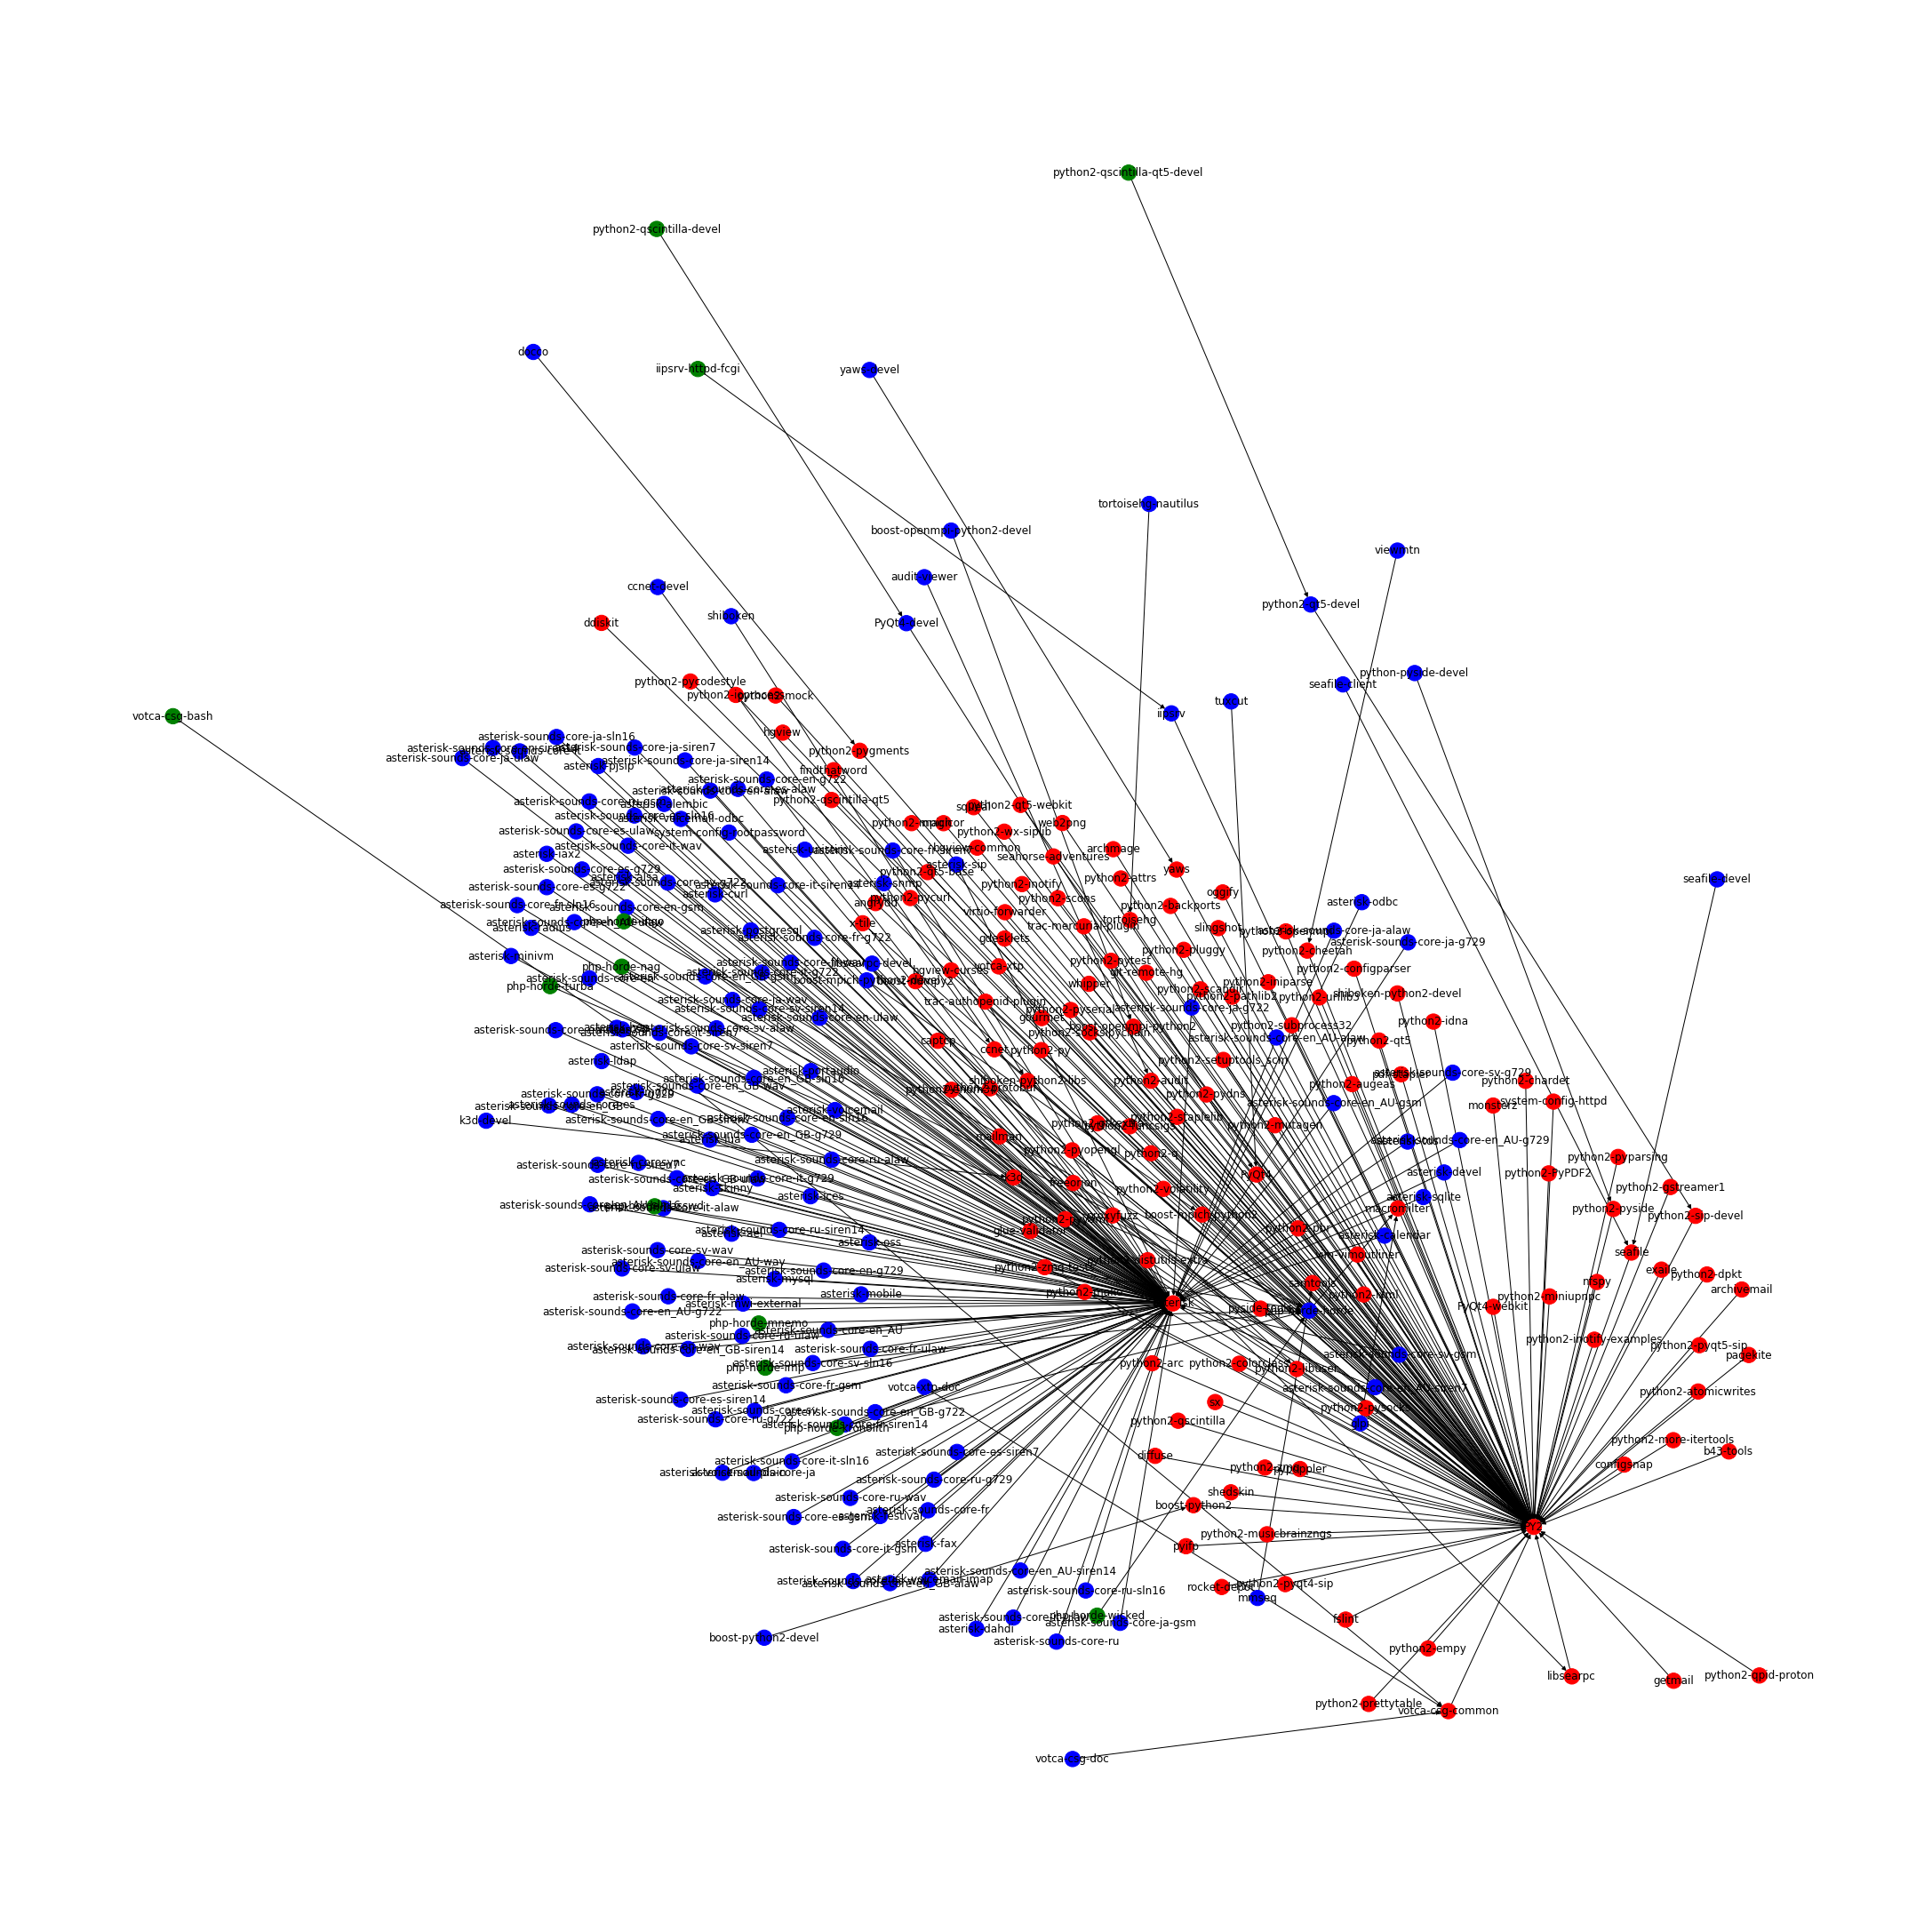

In [29]:
plt_draw(g, node_colors)

## List of packages and theirs paths to Python 2 (including the packages in the first wave)

In [30]:
len(waves)

4

In [31]:
with open("packages.txt", "w") as packages_file:
    binary_packages = list(chain(*[waves[str(n)] for n in waves.keys()]))
    print("Total packages", len(binary_packages))
    for package in sorted(binary_packages):
        path = list(all_simple_paths(g, package, 'PY2'))[0]
        line = f"{package} ({' → '.join(path)})"
        print(line)
        print(line, file=packages_file)

!scp packages.txt fedorapeople.org:public_html/ >/dev/null

Total packages 299
PyQt4 (PyQt4 → PY2)
PyQt4-devel (PyQt4-devel → PyQt4 → PY2)
PyQt4-webkit (PyQt4-webkit → PY2)
angrydd (angrydd → PY2)
archivemail (archivemail → PY2)
archmage (archmage → PY2)
asterisk (asterisk → PY2)
asterisk-ael (asterisk-ael → asterisk → PY2)
asterisk-alembic (asterisk-alembic → asterisk → PY2)
asterisk-alsa (asterisk-alsa → asterisk → PY2)
asterisk-calendar (asterisk-calendar → asterisk → PY2)
asterisk-corosync (asterisk-corosync → asterisk → PY2)
asterisk-curl (asterisk-curl → asterisk → PY2)
asterisk-dahdi (asterisk-dahdi → asterisk → PY2)
asterisk-devel (asterisk-devel → asterisk → PY2)
asterisk-fax (asterisk-fax → asterisk → PY2)
asterisk-festival (asterisk-festival → asterisk → PY2)
asterisk-hep (asterisk-hep → asterisk → PY2)
asterisk-iax2 (asterisk-iax2 → asterisk → PY2)
asterisk-ices (asterisk-ices → asterisk → PY2)
asterisk-ldap (asterisk-ldap → asterisk → PY2)
asterisk-lua (asterisk-lua → asterisk → PY2)
asterisk-mgcp (asterisk-mgcp → asterisk → PY2)
a

## List of all SRPMs and theirs RPMs

In [32]:
inverse_srpm_map = {}
for srpm, pkgs in srpm_mapping.items():
    inverse_srpm_map.update({pkg: srpm for pkg in pkgs})

In [33]:
srpms = defaultdict(list)
for package in binary_packages:
    try:
        srpm = inverse_srpm_map[package]
    except KeyError:
        srpm = "N/A"
    srpms[srpm].append(package)

## List of affected maintainers and their binary RPMs

In [34]:
affected_maintainers = defaultdict(list)
for package in binary_packages:
    try:
        srpm = inverse_srpm_map[package]
    except KeyError:
        srpm = "N/A"
    for maintainer in maintainers.get(srpm, []):
        affected_maintainers[maintainer].append(package)

with open("affected_maintainers.txt", "w") as affected_maintainer_file:
    for maintainer, pkgs in sorted(affected_maintainers.items(), key=lambda x: x[0]):
        line = f"{maintainer} - {', '.join(pkgs)}"
        print(line)
        print(line, file=affected_maintainer_file)

!scp affected_maintainers.txt fedorapeople.org:public_html/ >/dev/null

aarem - python2-staplelib, pdf-stapler, python2-more-itertools, python2-PyPDF2
abbot - python2-protobuf
abompard - python2-urllib3, python2-pysocks, python2-mako
amluto - python2-musicbrainzngs
apevec - python2-prettytable, python2-pbr, python2-pyparsing, python2-distutils-extra
aviso - python2-scandir, python2-configparser
beckerde - python2-miniupnpc
bowlofeggs - rocket-depot, python2-mako, python2-pycodestyle
brouhaha - python2-attrs, python2-enum34
carlwgeorge - python2-subprocess32
cheese - freeorion
churchyard - python2-pytest, python2-more-itertools, python2-pluggy, python2-pygments
cicku - diffuse, exaile, python2-mutagen
clalance - python2-prettytable
corsepiu - k3d, k3d-devel
cstratak - python2-setuptools_scm
ctria - configsnap
cverna - python2-mako
deji - exaile, python2-openmpi, python2-mpich
denisarnaud - boost-openmpi-python2, boost-python2, boost-mpich-python2, boost-numpy2, boost-openmpi-python2-devel, boost-python2-devel, boost-mpich-python2-devel
dledford - python2-op

## Combined structure

In [35]:
structure = defaultdict(lambda: defaultdict(list))
for binary_pkg in binary_packages:
    try:
        srpm = inverse_srpm_map[binary_pkg]
        srpm_maintainers = maintainers[srpm]
    except KeyError:
        srpm = "N/A"
        srpm_maintainers = ["N/A"]
    for maintainer in srpm_maintainers:
        structure[maintainer][srpm].append(binary_pkg)

# Build dependencies (direct)

In [36]:
srpm_dependants = []
for package in sorted(binary_packages):
    build_requires = !repoquery --repo={REPO}-source --repo={REPO} --qf "%{{NAME}} %{{ARCH}}" --whatrequires {package} 2>/dev/null | grep " src$" | cut -d " " -f 1
    print(f"{package} in required in build time by {build_requires}")
    for srpm in build_requires:
        if srpm in srpms.keys() or srpm in srpm_dependants:
            print(f"✅ {srpm} is already in the graph")
            continue
        if srpm in source_exc:
            print(f"✅ {srpm} in in the list of source ackages with exceptions")
            continue
        try:
            rpms = srpm_mapping[srpm]
        except KeyError:
            print(f"Cannot get RPMs for {srpm}")
            continue
        if any([p.startswith("python2-") for p in rpms]):
            print(f"✅ {srpm} provides python2 subpackage - {rpms}")
            continue
        
        srpm_dependants.append(srpm)
        g.add_edge(srpm, package)
        srpm_maintainers = maintainers[srpm]
        for maintainer in srpm_maintainers:
            structure[maintainer][srpm].insert(0, "SRPM")  # For these special cases, we'll generate path for SRPM

PyQt4 in required in build time by []
PyQt4-devel in required in build time by ['hgview', 'python-poppler-qt4', 'qscintilla']
✅ hgview is already in the graph
✅ qscintilla is already in the graph
PyQt4-webkit in required in build time by []
angrydd in required in build time by []
archivemail in required in build time by []
archmage in required in build time by []
asterisk in required in build time by []
asterisk-ael in required in build time by []
asterisk-alembic in required in build time by []
asterisk-alsa in required in build time by []
asterisk-calendar in required in build time by []
asterisk-corosync in required in build time by []
asterisk-curl in required in build time by []
asterisk-dahdi in required in build time by []
asterisk-devel in required in build time by []
asterisk-fax in required in build time by []
asterisk-festival in required in build time by []
asterisk-hep in required in build time by []
asterisk-iax2 in required in build time by []
asterisk-ices in required i

captcp in required in build time by []
ccnet in required in build time by []
ccnet-devel in required in build time by ['seafile', 'seafile-client']
✅ seafile is already in the graph
✅ seafile-client is already in the graph
configsnap in required in build time by []
ddiskit in required in build time by []
diffuse in required in build time by []
docco in required in build time by ['nodejs-snockets', 'nodejs-watchit']
exaile in required in build time by []
findthatword in required in build time by []
freeorion in required in build time by []
fslint in required in build time by []
gdesklets in required in build time by []
getmail in required in build time by []
git-remote-hg in required in build time by []
glpi in required in build time by []
glue-validator in required in build time by []
gourmet in required in build time by []
hgview in required in build time by []
hgview-common in required in build time by []
hgview-curses in required in build time by []
iipsrv in required in build time 

python2-staplelib in required in build time by []
python2-subprocess32 in required in build time by ['ioprocess']
✅ ioprocess is already in the graph
python2-urllib3 in required in build time by []
python2-volatility in required in build time by []
python2-wx-siplib in required in build time by []
python2-zmq in required in build time by []
python2-zmq-tests in required in build time by []
rocket-depot in required in build time by []
samtools in required in build time by []
seafile in required in build time by []
seafile-client in required in build time by []
seafile-devel in required in build time by ['seafile-client']
✅ seafile-client is already in the graph
seahorse-adventures in required in build time by []
shedskin in required in build time by []
shiboken in required in build time by []
shiboken-python2-devel in required in build time by ['python-pyside']
✅ python-pyside is already in the graph
shiboken-python2-libs in required in build time by []
slingshot in required in build ti

### Save

In [37]:
with open("structure.json", "w") as fh:
    json.dump(structure, fh)

### Load

In [38]:
with open("structure.json") as fh:
    structure = json.load(fh)

# Final outputs

## Package structure with paths

In [39]:
with open("report.txt", "w") as report_file:
    for maintainer in sorted(structure.keys()):
        # Skip orphans and unknown maintainers
        if maintainer in ("N/A", "orphan"):
            continue
        lines = []
        lines.append(maintainer)
        for srpm in sorted(structure[maintainer]):
            # Skip orphaned packages
            if srpm in srpm_orphans:
                continue
            lines.append(f"  {srpm}")
            rpms = sorted(structure[maintainer][srpm])
            if srpm in rpms:
                rpms.remove(srpm)
                rpms.insert(0, srpm)
            for rpm in rpms:
                marker = "→ "
                if rpm == "SRPM":
                    rpm = srpm
                    marker = "BuildRequires: "

                # Mark all orphaned packages in the path by (!)
                path = list(all_simple_paths(g, rpm, 'PY2'))[0]
                for index, package in enumerate(path):
                    try:
                        if inverse_srpm_map[package] in srpm_orphans:
                            path[index] = f"{package} (!)"
                    except KeyError:
                        pass

                if path[0] == srpm:
                    del path[0]
                    str_path = marker + ' → '.join(path)
                    line = f"    ({str_path})"
                else:
                    del path[0]
                    str_path = '→ ' + ' → '.join(path)
                    line = f"    {rpm} ({str_path})"
                lines.append(line)

        if any([True for l in lines if l.startswith(" "*4)]):
            print("\n".join(lines))
            print("\n".join(lines), file=report_file)

!scp report.txt fedorapeople.org:public_html/ >/dev/null

aarem
  pdf-stapler
    (→ PY2)
    python2-staplelib (→ PY2)
  python-PyPDF2
    python2-PyPDF2 (→ PY2)
  python2-more-itertools
    (→ PY2)
abbot
  protobuf
    python2-protobuf (→ PY2)
abompard
  python-mako
    python2-mako (→ PY2)
  python-pysocks
    python2-pysocks (→ PY2)
  python-urllib3
    python2-urllib3 (→ PY2)
alsadi
  dumb-init
    (BuildRequires: python2-mock → PY2)
amluto
  python-musicbrainzngs
    python2-musicbrainzngs (→ PY2)
apevec
  pyparsing
    python2-pyparsing (→ PY2)
  python-distutils-extra
    python2-distutils-extra (→ PY2)
  python-pbr
    python2-pbr (→ PY2)
  python-prettytable
    python2-prettytable (→ PY2)
aviso
  python-configparser
    python2-configparser (→ PY2)
  python-scandir
    python2-scandir (→ PY2)
beckerde
  miniupnpc
    python2-miniupnpc (→ PY2)
bowlofeggs
  python-mako
    python2-mako (→ PY2)
  python-pycodestyle
    python2-pycodestyle (→ PY2)
  rocket-depot
    (→ PY2)
brouhaha
  python-attrs
    python2-attrs (→ PY2)
  python-enu

## Recipients

In [40]:
recipients = set(structure.keys())
for recipient in sorted(recipients):
    if recipient in ("N/A", "orphan") or all([srpm in srpm_orphans for srpm in structure[recipient]]):
        continue
    print(f"{recipient}@fedoraproject.org")

aarem@fedoraproject.org
abbot@fedoraproject.org
abompard@fedoraproject.org
alsadi@fedoraproject.org
amluto@fedoraproject.org
apevec@fedoraproject.org
aviso@fedoraproject.org
beckerde@fedoraproject.org
bowlofeggs@fedoraproject.org
brouhaha@fedoraproject.org
bsjones@fedoraproject.org
carlwgeorge@fedoraproject.org
cheese@fedoraproject.org
churchyard@fedoraproject.org
cicku@fedoraproject.org
clalance@fedoraproject.org
corsepiu@fedoraproject.org
cstratak@fedoraproject.org
ctria@fedoraproject.org
cverna@fedoraproject.org
dang@fedoraproject.org
deji@fedoraproject.org
denisarnaud@fedoraproject.org
devos@fedoraproject.org
dledford@fedoraproject.org
dmalcolm@fedoraproject.org
dwrobel@fedoraproject.org
ersin@fedoraproject.org
fab@fedoraproject.org
fale@fedoraproject.org
farnz@fedoraproject.org
filiperosset@fedoraproject.org
fschwarz@fedoraproject.org
gbcox@fedoraproject.org
geertj@fedoraproject.org
genodeftest@fedoraproject.org
greghellings@fedoraproject.org
herczy@fedoraproject.org
hguemar@fedor

## Save

In [41]:
nx.write_adjlist(g, "full_graph.adjlist")

### Packages to retire

In [47]:
to_retire = set()
to_subdrop = dict()
for binary_pkg in binary_packages:
    try:
        srpm = inverse_srpm_map[binary_pkg]
    except KeyError:
        continue
    to_subdrop[srpm] = set()
    siblings = set(srpm_mapping[srpm])
    for sibling in siblings:
        if sibling in binary_packages:
            to_subdrop[srpm].add(sibling)
    if to_subdrop[srpm] == siblings:
        to_retire.add(srpm)

for srpm in sorted(to_retire):
    print(srpm)

angrydd
archivemail
archmage
asterisk
asterisk-sounds-core
audit-viewer
b43-tools
captcp
ccnet
configsnap
ddiskit
diffuse
docco
exaile
findthatword
fslint
gdesklets
getmail
git-remote-hg
glpi
glue-validator
gourmet
hgview
iipsrv
k3d
libsearpc
macromilter
magicor
mailman
mmseq
monsterz
nfspy
oggify
pagekite
pdf-stapler
php-horde-horde
php-horde-imp
php-horde-ingo
php-horde-kronolith
php-horde-mnemo
php-horde-nag
php-horde-passwd
php-horde-turba
php-horde-wicked
proxyfuzz
pyifp
pypoppler
pyside-tools
python-arc
python-backports
python-enum34
python-gtkextra
python-pydns
python-socksipychain
python-subprocess32
python-volatility
python2-more-itertools
python2-pluggy
python2-pytest
rocket-depot
seafile
seafile-client
seahorse-adventures
shedskin
slingshot
squeal
sx
system-config-httpd
system-config-rootpassword
tortoisehg
trac-authopenid-plugin
trac-mercurial-plugin
tuxcut
viewmtn
vim-vimoutliner
virtio-forwarder
whipper
x-tile
yaws


### Subpackages to drop

In [52]:
for srpm in sorted(to_subdrop):
    if srpm in to_retire:
        continue
    subpkgs = ', '.join(sorted(to_subdrop[srpm]))
    print(f'{srpm}: {subpkgs}')

PyQt4: PyQt4, PyQt4-devel, PyQt4-webkit
PyYAML: python2-pyyaml
audit: python2-audit
boost: boost-mpich-python2, boost-mpich-python2-devel, boost-numpy2, boost-openmpi-python2, boost-openmpi-python2-devel, boost-python2, boost-python2-devel
freeorion: freeorion
gif2png: web2png
ioprocess: python2-ioprocess
libuser: python2-libuser
miniupnpc: python2-miniupnpc
mpich: python2-mpich
openmpi: python2-openmpi
protobuf: python2-protobuf
pyparsing: python2-pyparsing
pyserial: python2-pyserial
python-PyPDF2: python2-PyPDF2
python-atomicwrites: python2-atomicwrites
python-attrs: python2-attrs
python-augeas: python2-augeas
python-cheetah: python2-cheetah
python-colorclass: python2-colorclass
python-configparser: python2-configparser
python-distutils-extra: python2-distutils-extra
python-dpkt: python2-dpkt
python-empy: python2-empy
python-funcsigs: python2-funcsigs
python-gstreamer1: python2-gstreamer1
python-idna: python2-idna
python-iniparse: python2-iniparse
python-inotify: python2-inotify, pyt